In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from helper_functions import calculate_DGv3, minimize_mol, get_dihedrals_by_name
import yaml
solvent_dict = yaml.load(open('solvents.yml', 'r'), Loader=yaml.FullLoader)["solvent_mapping_dict"]
import numpy as np
import matplotlib.pyplot as plt

In [31]:
mol = Chem.MolFromSmiles('COCCO')
mol = Chem.AddHs(mol)

traj, mol = calculate_DGv3(mol,1000,True,0.2)

In [32]:
opt_mol,opt_traj,ene = minimize_mol(mol,"tip3p","../MachineLearning/trained_models/ProductionRun_seed_1612_49_ckpt.pt",solvent_dict,return_traj=True)

Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC


/localhome/kpaul/small_molecule_multisolvent/Simulation/Simulator.py:937: UserWarning: Platform not available, defaulting to CPU
  warnings.warn("Platform not available, defaulting to CPU")


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


[W manager.cpp:335] Warning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (function runCudaFusionGroup)
0it [00:00, ?it/s]


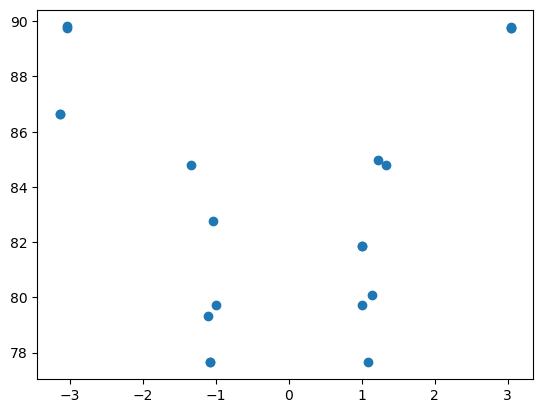

In [33]:
plt.scatter(get_dihedrals_by_name(opt_traj,"O1","C2","C3","O2"),ene)

In [34]:
solvent_list = ["Water","DMSO","Methanol","Chloroform","THF","Benzene","Acetonitrile","Acetone","Pyridine"]

In [6]:
for solvent in solvent_list:
    for i in range(traj.n_frames):
        with open("QM_reference_calculations/input/%s_opt_%i.inp" % (solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

!CPCM({solvent})

""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")

In [7]:
for solvent in solvent_list:
    for i in range(traj.n_frames):
        with open("QM_reference_calculations/input/%s_opt_%i_SMD.inp" % (solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%CPCM SMD TRUE
    SMDSOLVENT "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")

In [8]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
""")

print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}
cd ${solvent}_${idx}
cp ../input/${solvent}_opt_${idx}.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}.inp > ${solvent}_opt_${idx}.out
""")

print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_SMD
cd ${solvent}_${idx}_SMD
cp ../input/${solvent}_opt_${idx}_SMD.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_SMD.inp > ${solvent}_opt_${idx}_SMD.out
""")

print("""
for solvent in Water DMSO Methanol Chloroform THF Benzene Acetonitrile Acetone Pyridine
      do
      sbatch --array=0-19 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh $solvent \$SLURM_ARRAY_TASK_ID"
      done
""")

print("""
cat Water_*/Water_opt_*.out | grep "Final Gibbs free energy" | awk '{print $6}' > Water_energies.txt
""")


module load stack/2024-06
module load openmpi/4.1.6
module load orca


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}
cd ${solvent}_${idx}
cp ../input/${solvent}_opt_${idx}.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}.inp > ${solvent}_opt_${idx}.out


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_SMD
cd ${solvent}_${idx}_SMD
cp ../input/${solvent}_opt_${idx}_SMD.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_SMD.inp > ${solvent}_opt_${idx}_SMD.out


for solvent in Water DMSO Methanol Chloroform THF Benzene Acetonitrile Acetone Pyridine
      do
      sbatch --array=0-19 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh $solvent \$SLURM_ARRAY_TASK_ID"
      done


cat Water_*/Water_opt_*.out | grep "

### Read in results

In [9]:
mol.GetNumConformers()

256

In [10]:
i

255

In [35]:
import pandas as pd
import os
from helper_functions import mol_to_traj, kjmol_to_prop, get_cluster_asignments_ordered

In [36]:
orca_trajs = {}
orca_energies = {}
orca_props = {}
orca_mols = {}
orca_ds = {}
orca_deltas = {}
orca_populations = {}

folder = "/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations/"
additional_str = "_SMD"
# additional_str = ""

for solvent in solvent_list:
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(mol.GetNumConformers())
    for i in range(mol.GetNumConformers()):
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                df = pd.read_table(wfolder + "%s_opt_%i%s.xyz" % (solvent,i,additional_str),skiprows=2,delim_whitespace=True,names=['element','x','y','z'])
                ac_mol = Chem.Mol(mol)
                conf = ac_mol.GetConformer(i)
                for j in range(ac_mol.GetNumAtoms()):
                    conf.SetAtomPosition(j, [df.x[j],df.y[j],df.z[j]])
            except Exception as e:
                print(e)
                energies[i] = np.inf

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] = float(line.split()[5]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf

    orca_mols[solvent] = ac_mol
    orca_trajs[solvent] = mol_to_traj(ac_mol)
    orca_energies[solvent] = energies
    orca_ds[solvent] = get_dihedrals_by_name(orca_trajs[solvent],"O1","C2","C3","O2").flatten()
    orca_deltas[solvent] = np.min(orca_energies[solvent][np.abs(orca_ds[solvent]) < 2]) - np.min(orca_energies[solvent][np.abs(orca_ds[solvent]) > 2])


    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(orca_trajs[solvent],orca_energies[solvent],thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"O1","C2","C3","O2").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    orca_populations[solvent] = 1-min_pre


/localhome/kpaul/small_molecule_multisolvent/Simulation/helper_functions.py:285: RuntimeWarning: invalid value encountered in subtract
  (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])
/localhome/kpaul/small_molecule_multisolvent/Simulation/helper_functions.py:285: RuntimeWarning: invalid value encountered in subtract
  (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])
/localhome/kpaul/small_molecule_multisolvent/Simulation/helper_functions.py:285: RuntimeWarning: invalid value encountered in subtract
  (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])
/localhome/kpaul/small_molecule_multisolvent/Simulation/helper_functions.py:285: RuntimeWarning: invalid value encountered in subtract
  (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])


In [37]:
orca_populations

{'Water': 0.07388355620403197,
 'DMSO': 0.05721119353257431,
 'Methanol': 0.06770623410842713,
 'Chloroform': 0.05599275393795389,
 'THF': 0.048959604056899364,
 'Benzene': 0.0347778033815721,
 'Acetonitrile': 0.03863798441468447,
 'Acetone': 0.038123723233767226,
 'Pyridine': 0.04184139470151671}

In [38]:
reference_JHHs = {"Methanol": 9.77,"Acetone":5.5+4.6,"Chloroform":9.16,"Benzene":9.42,"Acetonitrile":5.5+4.6,"Water":9.32,"DMSO":5.62+4.77,"Pyridine":10.11,"THF":10.11}

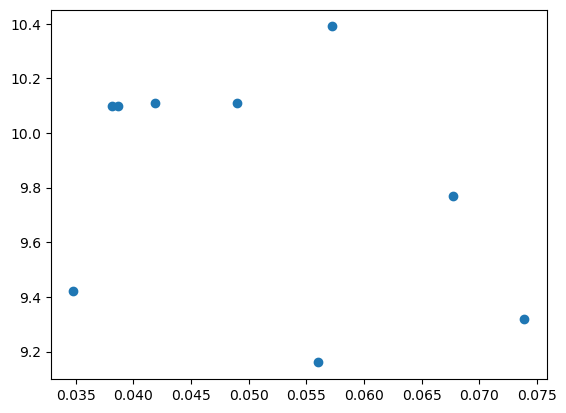

In [39]:
delta_Gs = np.array([orca_deltas[solvent] for solvent in solvent_list])
JHHs = np.array([reference_JHHs[solvent] for solvent in solvent_list])
smd_populations = [orca_populations[solvent] for solvent in solvent_list]
plt.scatter(smd_populations,JHHs)

#### Setup COSMO-RS calculations

In [16]:
for solvent in solvent_list:
    traj = orca_trajs[solvent]
    for i in range(traj.n_frames):
        with open("QM_reference_calculations/input/%s_opt_%i_COSMORS.inp" % (solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%cosmors
    solvent "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")

In [17]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_COSMORS
cd ${solvent}_${idx}_COSMORS
cp ../input/${solvent}_opt_${idx}_COSMORS.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_COSMORS.inp > ${solvent}_opt_${idx}_COSMORS.out
""")


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_COSMORS
cd ${solvent}_${idx}_COSMORS
cp ../input/${solvent}_opt_${idx}_COSMORS.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_COSMORS.inp > ${solvent}_opt_${idx}_COSMORS.out



##### VAC

In [18]:
for solvent in solvent_list:
    traj = orca_trajs[solvent]
    for i in range(traj.n_frames):
        with open("QM_reference_calculations/input/%s_opt_%i_VAC.inp" % (solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")

In [19]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_VAC
cd ${solvent}_${idx}_VAC
cp ../input/${solvent}_opt_${idx}_VAC.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_VAC.inp > ${solvent}_opt_${idx}_VAC.out
""")


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
echo $solvent $idx
mkdir -p ${solvent}_${idx}_VAC
cd ${solvent}_${idx}_VAC
cp ../input/${solvent}_opt_${idx}_VAC.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_VAC.inp > ${solvent}_opt_${idx}_VAC.out



#### Read COSMORS results

In [40]:
from helper_functions import get_cluster_asignments_ordered

In [41]:
cosmo_energies = {}
cosmo_props = {}
cosmo_mols = {}
cosmo_ds = {}
cosmo_deltas = {}
cosmo_trajs = {}
cosmors_populations = {}

folder = "/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations/"

for solvent in solvent_list:
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(mol.GetNumConformers())
    for i in range(mol.GetNumConformers()):
        additional_str = "_COSMORS"
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):
            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Free energy of solvation (dGsolv)" in line:
                            energies[i] = float(line.split()[6]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf
        additional_str = "_VAC"
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):
            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] += float(line.split()[5]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf

    cosmo_mols[solvent] = orca_mols[solvent]
    cosmo_trajs[solvent] = orca_trajs[solvent]
    cosmo_energies[solvent] = energies
    cosmo_ds[solvent] = get_dihedrals_by_name(cosmo_trajs[solvent],"O1","C2","C3","O2").flatten()
    cosmo_deltas[solvent] = np.min(cosmo_energies[solvent][np.abs(cosmo_ds[solvent]) < 2]) - np.min(cosmo_energies[solvent][np.abs(cosmo_ds[solvent]) > 2])

    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(cosmo_trajs[solvent],cosmo_energies[solvent],thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"O1","C2","C3","O2").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    cosmors_populations[solvent] = 1-min_pre


In [42]:
selection

array([ True,  True,  True, False,  True,  True, False, False])

In [43]:
min_pre

0.9582031488827338

In [24]:
import nglview
nglview.show_mdtraj(cluster_center_traj)

NGLWidget(max_frame=14)

(0.0, 0.15)

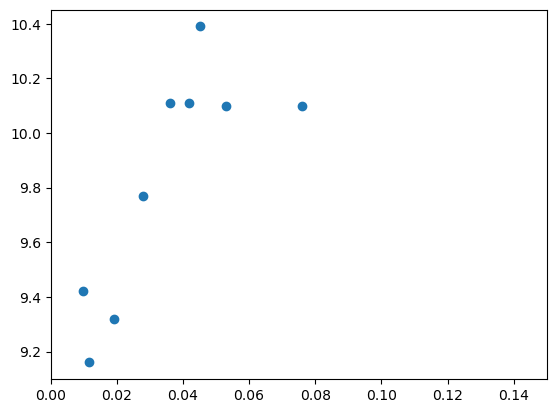

In [44]:
delta_Gs = np.array([cosmo_deltas[solvent] for solvent in solvent_list])
JHHs = np.array([reference_JHHs[solvent] for solvent in solvent_list])
cosmo_populations = [cosmors_populations[solvent] for solvent in solvent_list]
plt.scatter(cosmo_populations,JHHs)
plt.xlim(0,0.15)

### Repeat experiment with GNN

In [45]:
gnn_results = {}

In [46]:
solvent_dict.keys()

dict_keys(['tip3p', 'Chloroform', 'Methanol', 'DMSO', 'DMPU', 'Diethylether', 'Ethanol', 'DMF', 'DCM', 'Toluol', 'Benzol', 'Hexan', 'acetonitrile', 'acetone', 'aceticacid', '14dioxane', 'nitrobenzol', 'HMPA', 'MTBE', 'IPA', 'Hexafluorobenzene', 'pyridine', 'THF', 'Ethylacetate', 'Sulfolane', 'nitromethane', 'Butylformate', 'NMP', 'Octanol', 'cyclohexane', 'glycerin', 'carbontetrachloride', 'DME', '2Nitropropane', 'Trifluorotoluene', 'hexafluroacetone', 'Propionitrile', 'Benzonitrile', 'oxylol'])

In [47]:
from helper_functions import calculate_entropy

In [48]:
for solvent in ["tip3p","DMSO","Methanol","Chloroform","THF","Benzol","acetonitrile","acetone","pyridine"]:
    if solvent in gnn_results.keys():
        continue
    gnn_results[solvent] = calculate_entropy(Chem.Mol(mol),solvent,"../MachineLearning/trained_models/ProductionRun_seed_1612_49_ckpt.pt",solvent_dict,return_traj=True)

Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC


/localhome/kpaul/small_molecule_multisolvent/Simulation/Simulator.py:937: UserWarning: Platform not available, defaulting to CPU
  warnings.warn("Platform not available, defaulting to CPU")


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


In [132]:
gnn_deltas = []
gnn_pops = []
for solvent in ["tip3p","DMSO","Methanol","Chloroform","THF","Benzol","acetonitrile","acetone","pyridine"]:
    traj = gnn_results[solvent][0]
    ene = gnn_results[solvent][1]
    ds = get_dihedrals_by_name(traj,"O1","C2","C3","O2").flatten()
    delta = np.min(ene[np.abs(ds) < 2]) - np.min(ene[np.abs(ds) > 2])
    gnn_deltas.append(delta)
    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(traj,ene,thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"O1","C2","C3","O2").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    gnn_pops.append(1-min_pre)

#### Show results

In [133]:
from matplotlib import cm
def get_color_from_sd(sd):
    return cm.RdBu(sd/80)
colors = [get_color_from_sd(solvent_dict[solvent]["dielectric"]) for solvent in ["tip3p","DMSO","Methanol","Chloroform","THF","Benzol","acetonitrile","acetone","pyridine"]]

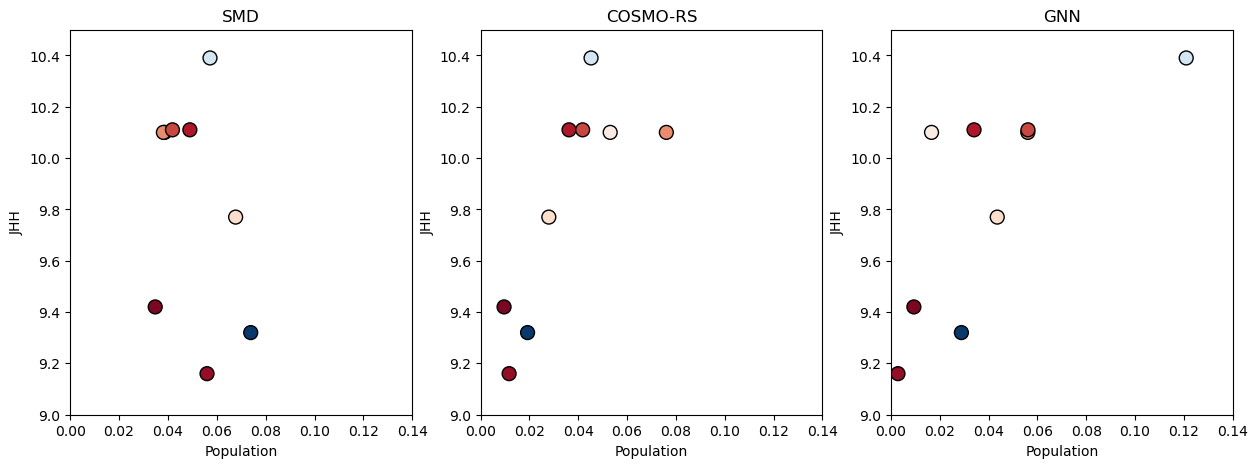

In [134]:
fig,axd = plt.subplot_mosaic([["SMD","ORCA","GNN"]],figsize=(15,5))

plot_style = {"c":colors,"edgecolors":"k","s":100}

axd["SMD"].scatter(smd_populations,JHHs,**plot_style)
axd["SMD"].set_title("SMD")
axd["ORCA"].scatter(cosmo_populations,JHHs,**plot_style)
axd["ORCA"].set_title("COSMO-RS")
axd["GNN"].scatter(gnn_pops,JHHs,**plot_style)
axd["GNN"].set_title("GNN")

for ax in axd.values():
    ax.set_xlabel("Population")
    ax.set_ylabel("JHH")
    ax.set_xlim([0,0.14])
    ax.set_ylim([9,10.5])

# fig.savefig("../Analysis/NextGenPlots/SMDvsCOSMORSvsGNN.pdf",bbox_inches="tight")

##### Calculate SMD correction energy

In [52]:
# Reload packages
%load_ext autoreload
%autoreload 2

In [53]:
from helper_functions import calculate_gnn_energies, calculate_gbneck_energy

In [56]:
adjusted_orca_populations = []

for so,solv in zip(solvent_list,["tip3p","DMSO","Methanol","Chloroform","THF","Benzol","acetonitrile","acetone","pyridine"]):

    gbe = calculate_gbneck_energy(Chem.Mol(orca_mols[so]),solv,solvent_dict)
    gnne = calculate_gnn_energies(Chem.Mol(orca_mols[so]),solv,"../MachineLearning/trained_models/ProductionRun_seed_1612_49_ckpt.pt",solvent_dict)

    adjusted_energies = orca_energies[so] - gbe + gnne
    traj = orca_trajs[so]
    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(traj,adjusted_energies,thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"O1","C2","C3","O2").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    adjusted_orca_populations.append(1-min_pre)

Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC


/localhome/kpaul/small_molecule_multisolvent/Simulation/Simulator.py:937: UserWarning: Platform not available, defaulting to CPU
  warnings.warn("Platform not available, defaulting to CPU")


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]
/localhome/kpaul/small_molecule_multisolvent/Simulation/helper_functions.py:285: RuntimeWarning: invalid value encountered in subtract
  (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


(0.0, 0.4)

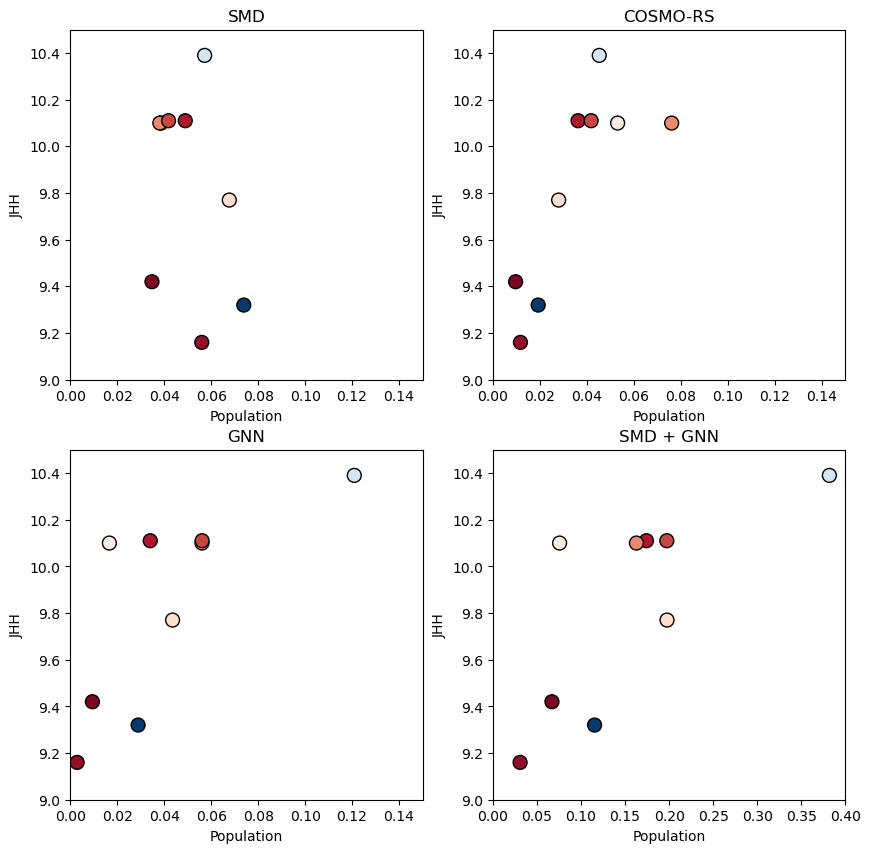

In [102]:
fig,axd = plt.subplot_mosaic([["SMD","ORCA"],["GNN","SMD + GNN"]],figsize=(10,10))

plot_style = {"c":colors,"edgecolors":"k","s":100}

axd["SMD"].scatter(smd_populations,JHHs,**plot_style)
axd["SMD"].set_title("SMD")
axd["ORCA"].scatter(cosmo_populations,JHHs,**plot_style)
axd["ORCA"].set_title("COSMO-RS")
axd["GNN"].scatter(gnn_pops,JHHs,**plot_style)
axd["GNN"].set_title("GNN")
axd["SMD + GNN"].scatter(adjusted_orca_populations,JHHs,**plot_style)
axd["SMD + GNN"].set_title("SMD + GNN")

for ax in axd.values():
    ax.set_xlabel("Population")
    ax.set_ylabel("JHH")
    ax.set_xlim([0,0.15])
    ax.set_ylim([9,10.5])

axd["SMD + GNN"].set_xlim([0,0.4])




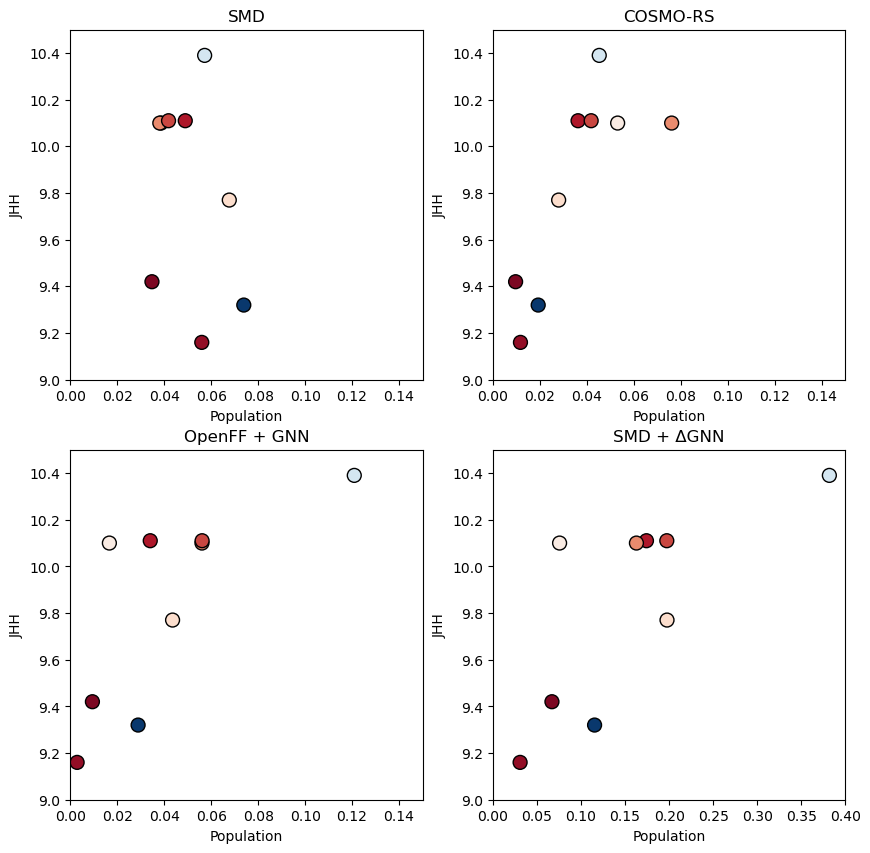

In [113]:
fig,axd = plt.subplot_mosaic([["SMD","ORCA"],["GNN","SMD + GNN"]],figsize=(10,10))

plot_style = {"c":colors,"edgecolors":"k","s":100}

axd["SMD"].scatter(smd_populations,JHHs,**plot_style)
axd["SMD"].set_title("SMD")
axd["ORCA"].scatter(cosmo_populations,JHHs,**plot_style)
axd["ORCA"].set_title("COSMO-RS")
axd["GNN"].scatter(gnn_pops,JHHs,**plot_style)
axd["GNN"].set_title("OpenFF + GNN")
axd["SMD + GNN"].scatter(adjusted_orca_populations,JHHs,**plot_style)
axd["SMD + GNN"].set_title("SMD + ΔGNN")

for ax in axd.values():
    ax.set_xlabel("Population")
    ax.set_ylabel("JHH")
    ax.set_xlim([0,0.15])
    ax.set_ylim([9,10.5])

axd["SMD + GNN"].set_xlim([0,0.4])
fig.savefig("../Analysis/NextGenPlots/SMDvsCOSMORSvsGNNvsSMD_GNN.pdf",bbox_inches="tight")

#### Go to predicted JHHsum

In [66]:
def get_predicted_JHHsum(population,Jt,Jg):

    Jgo = (Jt+Jg+Jg+Jg)/2
    Jto = (Jt+Jg)

    return population*Jto + (1-population)*Jgo

In [104]:
xs = np.linspace(0,0.4,10)
all_k = []
for Jg in np.linspace(1.5,2.5,5):
    for Jt in np.linspace(10,12,5):
        all_k.append(get_predicted_JHHsum(xs,Jt,Jg))

In [108]:
np.array(all_k).mean(axis=0)

array([ 8.5,  8.7,  8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1, 10.3])

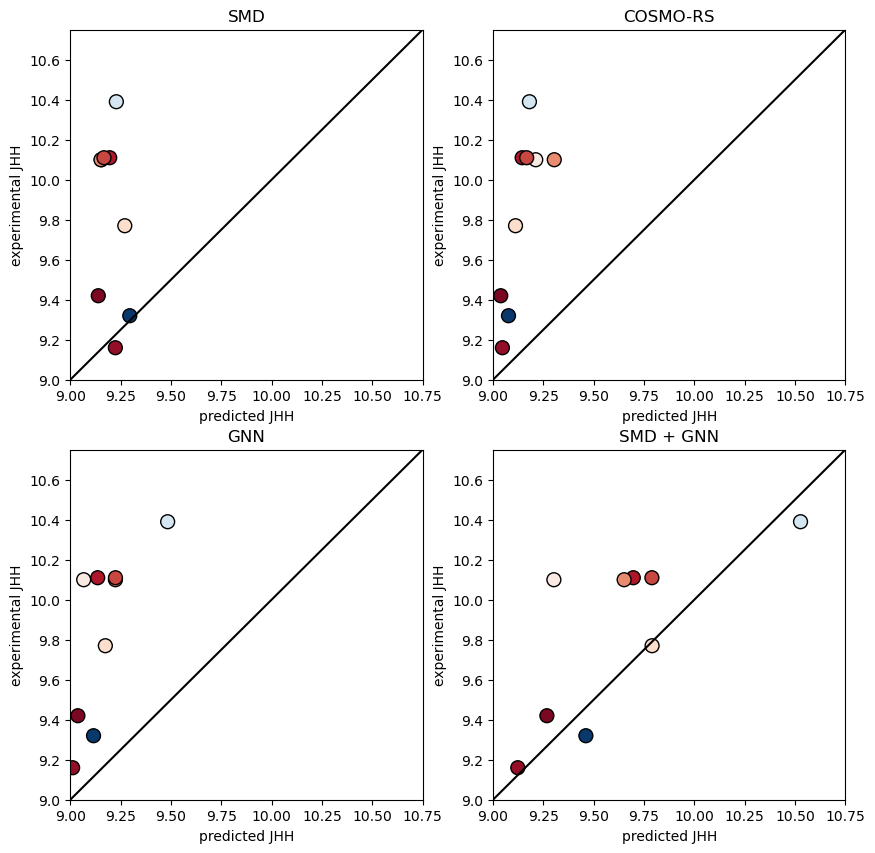

In [138]:
fig,axd = plt.subplot_mosaic([["SMD","ORCA"],["GNN","SMD + GNN"]],figsize=(10,10))

plot_style = {"c":colors,"edgecolors":"k","s":100}

Jt = 10.5
Jg = 2.5

axd["SMD"].scatter(get_predicted_JHHsum(np.array(smd_populations),Jt,Jg),JHHs,**plot_style)
axd["SMD"].set_title("SMD")
axd["ORCA"].scatter(get_predicted_JHHsum(np.array(cosmo_populations),Jt,Jg),JHHs,**plot_style)
axd["ORCA"].set_title("COSMO-RS")
axd["GNN"].scatter(get_predicted_JHHsum(np.array(gnn_pops),Jt,Jg),JHHs,**plot_style)
axd["GNN"].set_title("GNN")
axd["SMD + GNN"].scatter(get_predicted_JHHsum(np.array(adjusted_orca_populations),Jt,Jg),JHHs,**plot_style)
axd["SMD + GNN"].set_title("SMD + GNN")

for ax in axd.values():
    ax.set_xlabel("predicted JHH")
    ax.set_ylabel("experimental JHH")
    ax.set_xlim([9,10.75])
    ax.set_ylim([9,10.75])
    ax.axline([9,9],[10.5,10.5],color="k")

fig.savefig("../Analysis/NextGenPlots/SMDvsCOSMORSvsGNNvsSMD_GNN_JHHsum.pdf",bbox_inches="tight")

#### Calculate Metrics

In [135]:
from scipy.stats import linregress, pearsonr, kendalltau
# Pearson correlation coefficient
print(kendalltau(smd_populations,JHHs))
print(kendalltau(cosmo_populations,JHHs))
print(kendalltau(gnn_pops,JHHs))
print(kendalltau(adjusted_orca_populations,JHHs))

SignificanceResult(statistic=0.0, pvalue=1.0)
SignificanceResult(statistic=0.5144957554275265, pvalue=0.057779571123597245)
SignificanceResult(statistic=0.6859943405700353, pvalue=0.011412036386001651)
SignificanceResult(statistic=0.6288281455225323, pvalue=0.020394840183375906)


In [35]:
with open(wfolder + "%s_opt_%i.out" % (solvent,i)) as f:
    for line in f:
        if "Final Gibbs free energy" in line:
            energies[i] = float(line.split()[5])

In [84]:
kjmol_to_prop(np.array([delta_Gs[0],0]))

array([0.95067667, 0.04932333])

In [33]:
orca_ds

{'Water': array([[-1.2015382 ],
        [ 1.9765761 ],
        [-1.1569746 ],
        [ 0.8826163 ],
        [ 0.37673235],
        [-2.7068353 ],
        [ 1.1634893 ],
        [ 2.4161248 ],
        [-1.9365362 ],
        [-1.5941923 ],
        [-3.1106036 ],
        [-2.8435807 ],
        [ 1.2601275 ],
        [ 1.231181  ],
        [ 2.4582295 ],
        [ 2.3625553 ],
        [-0.46865267],
        [-2.185256  ],
        [-2.3533106 ],
        [ 0.9332955 ]], dtype=float32),
 'DMSO': array([[-1.2015382 ],
        [ 1.9765761 ],
        [-1.1569746 ],
        [ 0.8826163 ],
        [ 0.37673235],
        [-2.7068353 ],
        [ 1.1634893 ],
        [ 2.4161248 ],
        [-1.9365362 ],
        [-1.5941923 ],
        [-3.1106036 ],
        [-2.8435807 ],
        [ 1.2601275 ],
        [ 1.231181  ],
        [ 2.4582295 ],
        [ 2.3625553 ],
        [-0.46865267],
        [-2.185256  ],
        [-2.3533106 ],
        [ 0.9307636 ]], dtype=float32),
 'Methanol': array([[-1.20153

In [29]:
ds = get_dihedrals_by_name()

{'Water': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6d1d9b70>,
 'DMSO': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfe7790>,
 'Methanol': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfc52a0>,
 'Chloroform': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfe6470>,
 'THF': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cf82050>,
 'Benzene': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfe4340>,
 'Acetonitrile': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfd4760>,
 'Acetone': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfe7cd0>,
 'Pyridine': <mdtraj.Trajectory with 20 frames, 13 atoms, 1 residues, without unitcells at 0x786a6cfd6ad0>}

In [30]:
import nglview
nglview.show_mdtraj(orca_trajs["Water"])

NGLWidget(max_frame=19)

In [19]:
df = pd.read_table(wfolder + "%s_opt_%i.xyz" % (solvent,i),delim_whitespace=True,names=['element','x','y','z'],skiprows=2)

# Molecular Balances

#### Get GNN minimised structures

In [2]:
import numpy as np
import mdtraj
import os

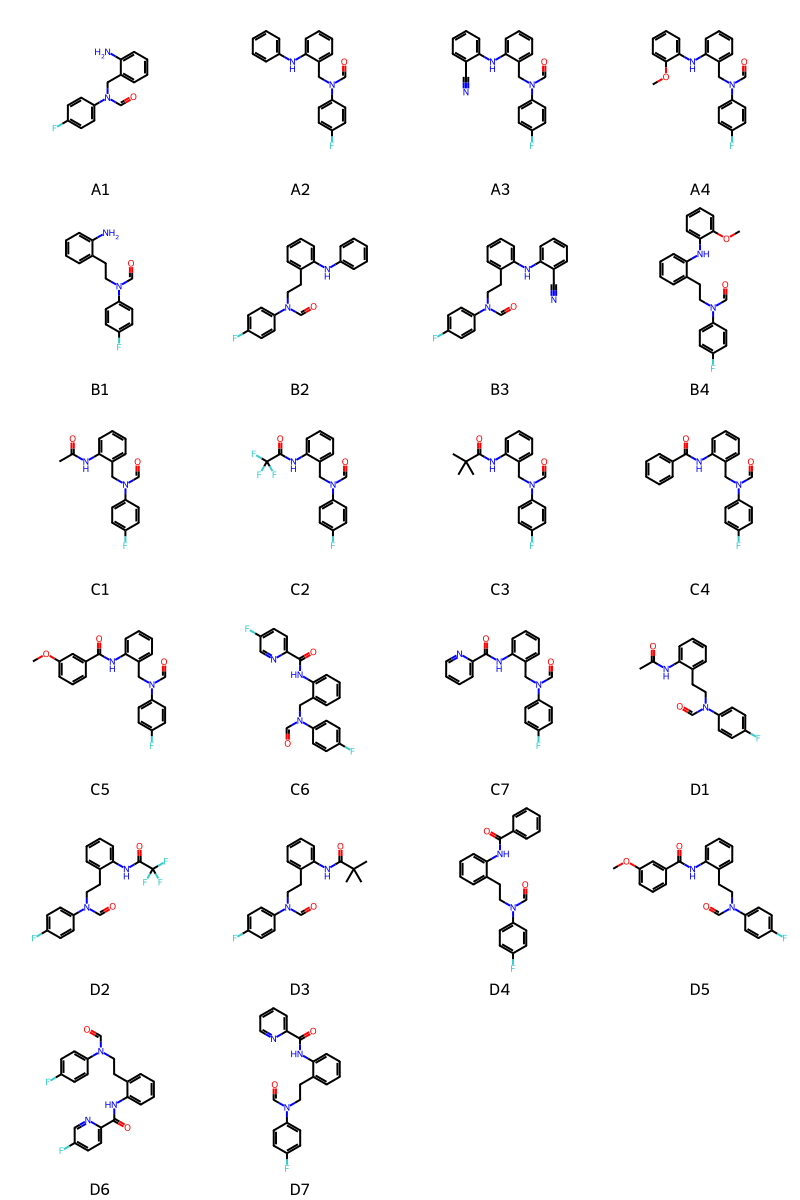

In [3]:
# New namingscheme

set1 = ["N","Nc2ccccc2","Nc2ccccc(C#N)2","Nc2ccccc(OC)2"]
set2 = ["NC(=O)C","NC(=O)C(F)(F)F","NC(=O)C(C)(C)C","NC(=O)c2ccccc2","NC(=O)c2cc(OC)ccc2","NC(=O)c2ccc(F)cn2","NC(=O)c2ccccn2"]
As, Bs, Cs, Ds = [], [], [], []
for X in set1:
    As.append("Fc1ccc(N(C=O)Cc2ccccc2%s)cc1" % X)
    Bs.append("Fc1ccc(N(C=O)CCc2ccccc2%s)cc1" % X)
for X in set2:
    Cs.append("Fc1ccc(N(C=O)Cc2ccccc2%s)cc1" % X)
    Ds.append("Fc1ccc(N(C=O)CCc2ccccc2%s)cc1" % X)

all_compounds = As + Bs + Cs + Ds
labels = ["A%i" % (i+1) for i in range(len(As))] + ["B%i" % (i+1) for i in range(len(Bs))] + ["C%i" % (i+1) for i in range(len(Cs))] + ["D%i" % (i+1) for i in range(len(Ds))]

# visualize all molecules with rdkit in grid
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
mols = [Chem.MolFromSmiles(x) for x in all_compounds]

img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=labels)
img

### Setup SMD calculations

In [29]:
solvent_list = ["Chloroform","ethylacetate","thf","DCM","Acetone","ethanol","methanol","DMSO","acetonitrile"]
solvent_list_rename = ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]


In [253]:
compound_name = "A1"

In [254]:
traj = mdtraj.load("../Analysis/MB_results/%s/%s_Chloroform_cluster_center.h5" % (compound_name,compound_name))

/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [208]:
os.system(f"mkdir -p QM_reference_calculations_Molecular_Balances_{compound_name}/input")
submission_string = ""
for s,solvent in enumerate(solvent_list):
    traj = mdtraj.load(f"../Analysis/MB_results/{compound_name}/{compound_name}_{solvent_list_rename[s]}_cluster_center.h5")
    ene = np.load(f"../Analysis/MB_results/{compound_name}/{compound_name}_{solvent_list_rename[s]}_cluster_center_free_energy.npy")
    for i in range(traj.n_frames):
        with open("QM_reference_calculations_Molecular_Balances_%s/input/%s_opt_%i_SMD.inp" % (compound_name,solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%CPCM SMD TRUE
    SMDSOLVENT "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")
    submission_string += f"""
sbatch --array=0-%i -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh %s $SLURM_ARRAY_TASK_ID %s" """ % (traj.n_frames-1,solvent,compound_name)

/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

In [209]:
print(submission_string)


sbatch --array=0-282 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh Chloroform $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-421 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh ethylacetate $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-375 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh thf $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-290 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh DCM $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-383 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh Acetone $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-400 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh ethanol $SLURM_ARRAY_TASK_ID A3" 
sbatch --array=0-389 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh meth

In [200]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_SMD
cd ${solvent}_${idx}_SMD
cp ../input/${solvent}_opt_${idx}_SMD.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_SMD.inp > ${solvent}_opt_${idx}_SMD.out
""")

print("""
for solvent in Chloroform ethylacetate thf DCM Acetone ethanol methanol DMSO acetonitrile
      do
      sbatch --array=0-%i -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh $solvent \$SLURM_ARRAY_TASK_ID %s"
      done
"""%(traj.n_frames-1,compound_name))


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_SMD
cd ${solvent}_${idx}_SMD
cp ../input/${solvent}_opt_${idx}_SMD.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_SMD.inp > ${solvent}_opt_${idx}_SMD.out


for solvent in Chloroform ethylacetate thf DCM Acetone ethanol methanol DMSO acetonitrile
      do
      sbatch --array=0-355 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_SMD.sh $solvent \$SLURM_ARRAY_TASK_ID A3"
      done



In [4]:
import pandas as pd
from helper_functions import mol_to_traj, kjmol_to_prop

In [255]:
orca_trajs = {}
orca_energies = {}
orca_props = {}
orca_mols = {}
orca_ds = {}
orca_deltas = {}
orca_populations = {}

folder = "/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances_A1/"
additional_str = "_SMD"
# additional_str = ""

for solvent in solvent_list:
    w_traj = mdtraj.Trajectory(traj.xyz,traj.top)
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(w_traj.n_frames)
    for i in range(w_traj.n_frames):
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                df = pd.read_table(wfolder + "%s_opt_%i%s.xyz" % (solvent,i,additional_str),skiprows=2,delim_whitespace=True,names=['element','x','y','z'])
                xyz = np.zeros((w_traj.n_atoms,3))
                for j in range(w_traj.n_atoms):
                    xyz[j] = [df.x[j],df.y[j],df.z[j]]
                w_traj.xyz[i] = xyz
            except Exception as e:
                energies[i] = np.inf

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] = float(line.split()[5]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf

    # orca_mols[solvent] = ac_mol
    orca_trajs[solvent] = w_traj
    orca_energies[solvent] = energies
    orca_ds[solvent] = get_dihedrals_by_name(orca_trajs[solvent],"C4","N1","C5","O1").flatten()
    orca_deltas[solvent] = np.min(orca_energies[solvent][np.abs(orca_ds[solvent]) < 2]) - np.min(orca_energies[solvent][np.abs(orca_ds[solvent]) > 2])

    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(orca_trajs[solvent],orca_energies[solvent],thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    orca_populations[solvent] = 1-min_pre

In [256]:
traj

<mdtraj.Trajectory with 43 frames, 31 atoms, 1 residues, without unitcells at 0x7459c81d3130>

In [251]:
w_traj.n_atoms

42

In [250]:
df.x

0     4.343548
1     3.471045
2     2.785838
3     1.866600
4     1.661769
5     0.729679
6     0.750913
7    -0.120201
8    -0.359105
9    -1.378597
10   -1.288837
11   -2.188674
12   -3.207397
13   -3.321575
14   -2.414737
15   -2.569062
16    2.365776
17    3.269920
18    2.956804
19    1.285077
20    1.664833
21    0.098077
22   -0.814194
23   -0.483962
24   -2.097573
25   -3.927420
26   -4.125267
27   -1.780784
28   -3.213540
29    2.215882
30    3.828362
Name: x, dtype: float64

In [135]:
from helper_functions import in_kjmol

In [141]:
in_kjmol(np.array([0.997,0.003]))

array([ 0.       , 14.3934173])

In [257]:
orca_populations

{'Chloroform': 0.9972996859718697,
 'ethylacetate': 0.9951327021133787,
 'thf': 0.9954728828154165,
 'DCM': 0.9946917893677732,
 'Acetone': 0.9905628271281538,
 'ethanol': 0.9852957516565224,
 'methanol': 0.9818575237156203,
 'DMSO': 0.9851241090478786,
 'acetonitrile': 0.9896797806304624}

In [161]:
solvent_list

['Chloroform',
 'ethylacetate',
 'thf',
 'DCM',
 'Acetone',
 'ethanol',
 'methanol',
 'DMSO',
 'acetonitrile']

In [7]:
solvent_list_rename = ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]
df = pd.read_csv("../Analysis/MB_experimental_references.csv",index_col=0)["A1"]
exp_values = np.array([eval(df[solvent])[0] for solvent in solvent_list_rename])
df["Ethylacetate"] = '(-10,2,0)'
pre_values = np.array([in_kjmol(np.array([orca_populations[solvent],1-orca_populations[solvent]]))[1]*-1 for solvent in solvent_list])

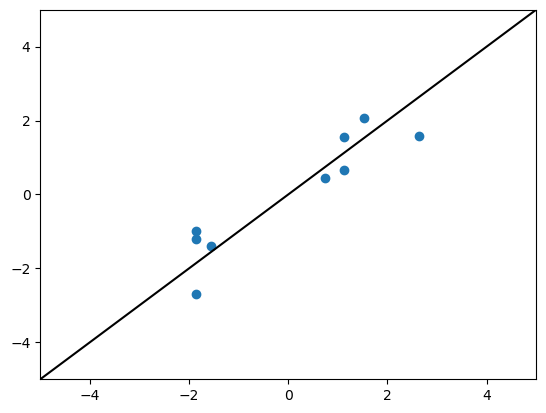

In [210]:
plt.scatter(exp_values-np.mean(exp_values),pre_values-np.mean(pre_values))
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.axline([0,0],[1,1],color="k")
# plt.axline([0,1],[1,2],color="k")
# plt.axline([0,-1],[1,0],color="k")


#### Add GNN

In [285]:
from helper_functions import calculate_gbneck_energy, calculate_gnn_energies

In [119]:
from rdkit.Geometry import Point3D
def traj_to_mol(traj, mol):
    n_confs = mol.GetNumConformers()
    n_atoms = mol.GetNumAtoms()
    for i in range(n_confs):
        conf = mol.GetConformer(i)
        for j in range(n_atoms):
            conf.SetAtomPosition(j, Point3D(float(traj.xyz[i][j][0]*10), float(traj.xyz[i][j][1]*10), float(traj.xyz[i][j][2]*10)))
    return mol

In [303]:
solvent_list

['Chloroform',
 'ethylacetate',
 'thf',
 'DCM',
 'Acetone',
 'ethanol',
 'methanol',
 'DMSO',
 'acetonitrile']

In [305]:
solvent_dict.keys()

dict_keys(['tip3p', 'Chloroform', 'Methanol', 'DMSO', 'DMPU', 'Diethylether', 'Ethanol', 'DMF', 'DCM', 'Toluol', 'Benzol', 'Hexan', 'acetonitrile', 'acetone', 'aceticacid', '14dioxane', 'nitrobenzol', 'HMPA', 'MTBE', 'IPA', 'Hexafluorobenzene', 'pyridine', 'THF', 'Ethylacetate', 'Sulfolane', 'nitromethane', 'Butylformate', 'NMP', 'Octanol', 'cyclohexane', 'glycerin', 'carbontetrachloride', 'DME', '2Nitropropane', 'Trifluorotoluene', 'hexafluroacetone', 'Propionitrile', 'Benzonitrile', 'oxylol'])

In [306]:

mol = Chem.MolFromSmiles(As[0])
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol,numConfs=orca_trajs["Chloroform"].n_frames)

adjusted_orca_populations = {}
for so,solv in zip(solvent_list,["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]):

    mol = traj_to_mol(orca_trajs[solvent],Chem.Mol(mol))

    gbe = calculate_gbneck_energy(Chem.Mol(mol),solv,solvent_dict)
    gnne = calculate_gnn_energies(Chem.Mol(mol),solv,"../MachineLearning/trained_models/ProductionRun_seed_1612_49_ckpt.pt",solvent_dict)

    adjusted_energies = orca_energies[so] - gbe + gnne
    traj = orca_trajs[so]
    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(traj,adjusted_energies,thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    adjusted_orca_populations[so] = (1-min_pre)


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC


/localhome/kpaul/small_molecule_multisolvent/Simulation/Simulator.py:937: UserWarning: Platform not available, defaulting to CPU
  warnings.warn("Platform not available, defaulting to CPU")


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
setting charges based on AM1BCC
All parallel systems have the same forces as the reference System


0it [00:00, ?it/s]


In [323]:
orca_populations

{'Chloroform': 0.9972996859718697,
 'ethylacetate': 0.9951327021133787,
 'thf': 0.9954728828154165,
 'DCM': 0.9946917893677732,
 'Acetone': 0.9905628271281538,
 'ethanol': 0.9852957516565224,
 'methanol': 0.9818575237156203,
 'DMSO': 0.9851241090478786,
 'acetonitrile': 0.9896797806304624}

In [307]:
adjusted_orca_populations

{'Chloroform': 0.9996332020162565,
 'ethylacetate': 0.9958044164747029,
 'thf': 0.9979929854904561,
 'DCM': 0.9992320131111573,
 'Acetone': 0.992411355188087,
 'ethanol': 0.9887284580533113,
 'methanol': 0.9817878451010357,
 'DMSO': 0.9736420513365074,
 'acetonitrile': 0.9945169946238093}

In [309]:
adjusted_pre_values = np.array([in_kjmol(np.array([adjusted_orca_populations[solvent],1-adjusted_orca_populations[solvent]]))[1]*-1 for solvent in solvent_list])

In [334]:
from matplotlib import cm
def get_color_from_sd(sd):
    return cm.RdBu(sd/80)
colors = [get_color_from_sd(solvent_dict[solvent]["dielectric"]) for solvent in ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]]

In [346]:
removed_pre = np.array(pre_values)
removed_gnn_pre = np.array(adjusted_pre_values)

exp_values = np.array(exp_values)
removed_pre = removed_pre[exp_values != -10]
removed_gnn_pre = removed_gnn_pre[exp_values != -10]
removed_exp = exp_values[exp_values != -10]
removed_colors = np.array(colors)[exp_values != -10]

In [347]:
removed_exp

array([-9.7, -7.4, -7. , -6.6, -5.5, -7. ])

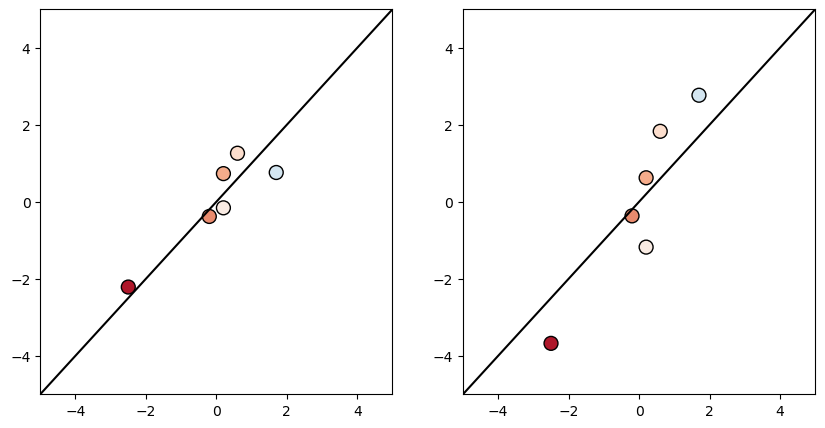

In [353]:
fig, axd = plt.subplot_mosaic([["SMD","SMD + GNN"]],figsize=(10,5))
marker_dict = {"c":removed_colors,"edgecolors":"k","s":100}

axd["SMD"].scatter(removed_exp-removed_exp.mean(),removed_pre-removed_pre.mean(),**marker_dict)
axd["SMD + GNN"].scatter(removed_exp-removed_exp.mean(),removed_gnn_pre-removed_gnn_pre.mean(),**marker_dict)

for ax in axd.values():
    ax.axline([0,0],[1,1],color="k")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)

##### Setup COSMO-RS calculations

In [373]:
submission_string = ""
for solvent in solvent_list:
    traj = orca_trajs[solvent]
    for i in range(traj.n_frames):
        with open("QM_reference_calculations_Molecular_Balances_%s/input/%s_opt_%i_COSMORS.inp" % (compound_name,solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%cosmors
    solvent "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]} {atompos[1]} {atompos[2]} \n")
            f.write("*")
    submission_string += f"""
sbatch --array=0-%i -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh %s \$SLURM_ARRAY_TASK_ID %s" """ % (traj.n_frames-1,solvent,compound_name)

In [375]:
nglview.show_mdtraj(orca_trajs["Chloroform"])

NGLWidget(max_frame=42)

In [369]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_COSMORS
cd ${solvent}_${idx}_COSMORS
cp ../input/${solvent}_opt_${idx}_COSMORS.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_COSMORS.inp > ${solvent}_opt_${idx}_COSMORS.out
""")


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_COSMORS
cd ${solvent}_${idx}_COSMORS
cp ../input/${solvent}_opt_${idx}_COSMORS.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_COSMORS.inp > ${solvent}_opt_${idx}_COSMORS.out



In [374]:
for solvent in solvent_list:
    traj = orca_trajs[solvent]
    for i in range(traj.n_frames):
        with open("QM_reference_calculations_Molecular_Balances_%s/input/%s_opt_%i_VAC.inp" % (compound_name,solvent,i),'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]} {atompos[1]} {atompos[2]} \n")
            f.write("*")
    submission_string += f"""
sbatch --array=0-%i -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_VAC.sh %s \$SLURM_ARRAY_TASK_ID %s" """ % (traj.n_frames-1,solvent,compound_name)
print(submission_string)


sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh Chloroform \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh ethylacetate \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh thf \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh DCM \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh Acetone \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_optimization_COSMORS.sh ethanol \$SLURM_ARRAY_TASK_ID A1" 
sbatch --array=0-42 -n 8 --time 04:00:00 --mem-per-cpu=4000 --tmp=4000 --wrap="bash run_one_o

In [363]:
print("""
module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_VAC
cd ${solvent}_${idx}_VAC
cp ../input/${solvent}_opt_${idx}_VAC.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_VAC.inp > ${solvent}_opt_${idx}_VAC.out
""")


module load stack/2024-06
module load openmpi/4.1.6
module load orca
solvent=$1
idx=$2
compound_name=$3
echo $solvent $idx
mkdir -p ${solvent}_${idx}_VAC
cd ${solvent}_${idx}_VAC
cp ../input/${solvent}_opt_${idx}_VAC.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca ${solvent}_opt_${idx}_VAC.inp > ${solvent}_opt_${idx}_VAC.out



### Analyse COSMO-RS results

In [382]:
cosmo_energies = {}
cosmo_props = {}
cosmo_mols = {}
cosmo_ds = {}
cosmo_deltas = {}
cosmo_trajs = {}
cosmors_populations = {}

folder = "/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances_A1/"

for solvent in solvent_list:
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(mol.GetNumConformers())
    for i in range(mol.GetNumConformers()):
        additional_str = "_COSMORS"
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):
            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Free energy of solvation (dGsolv)" in line:
                            energies[i] = float(line.split()[6]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf
        additional_str = "_VAC"
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):
            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] += float(line.split()[5]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf

    # cosmo_mols[solvent] = orca_mols[solvent]
    cosmo_trajs[solvent] = orca_trajs[solvent]
    cosmo_energies[solvent] = energies

    traj = cosmo_trajs[solvent]
    cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(traj,energies,thresh=0.05,energy_thresh=100)
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    cosmors_populations[solvent] = (1-min_pre)


In [384]:
cosmors_populations

{'Chloroform': 0.9860933791933892,
 'ethylacetate': 0.9842518769444923,
 'thf': 0.9712732931488285,
 'DCM': 0.9936825538761864,
 'Acetone': 0.9656989283293407,
 'ethanol': 0.9696920456808735,
 'methanol': 0.9573427245460407,
 'DMSO': 0.8875918473669147,
 'acetonitrile': 0.9716976030448183}

In [387]:
cosmors_pre = np.array([in_kjmol(np.array([cosmors_populations[solvent],1-cosmors_populations[solvent]]))[1]*-1 for solvent in solvent_list])

In [389]:
removed_cosmors_pre = np.array(cosmors_pre)
removed_cosmors_pre = removed_cosmors_pre[exp_values != -10]

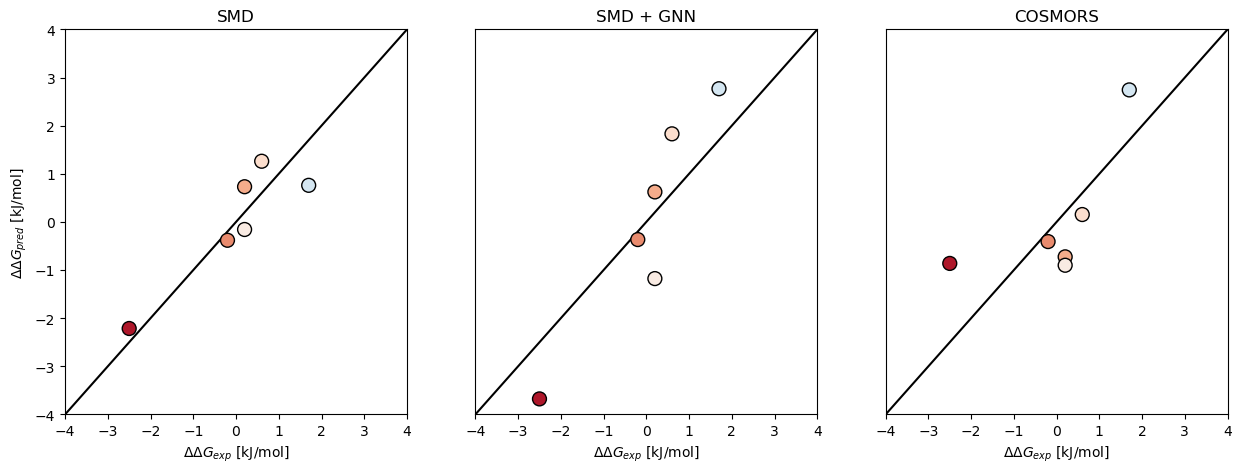

In [407]:
fig, axd = plt.subplot_mosaic([["SMD","SMD + GNN","COSMORS"]],figsize=(15,5))
marker_dict = {"c":removed_colors,"edgecolors":"k","s":100}


adjust = lambda x: x-x.mean()
lims_u = -4
lims_a = 4

# adjust = lambda x: x
# lims_u = -16
# lims_a = 0

axd["SMD"].scatter(adjust(removed_exp),adjust(removed_pre),**marker_dict)
axd["SMD"].set_title("SMD")
axd["SMD + GNN"].scatter(adjust(removed_exp),adjust(removed_gnn_pre),**marker_dict)
axd["SMD + GNN"].set_title("SMD + GNN")
axd["SMD + GNN"].get_yaxis().set_visible(False)
axd["COSMORS"].scatter(adjust(removed_exp),adjust(removed_cosmors_pre),**marker_dict)
axd["COSMORS"].set_title("COSMORS")
axd["COSMORS"].get_yaxis().set_visible(False)

for ax in axd.values():
    ax.axline([0,0],[1,1],color="k",zorder=0)
    ax.set_xlim(lims_u,lims_a)
    ax.set_ylim(lims_u,lims_a)
    ax.set_xlabel("$\Delta\Delta G_{exp}$ [kJ/mol]")
    ax.set_ylabel("$\Delta\Delta G_{pred}$ [kJ/mol]")

fig.savefig("../Analysis/NextGenPlots/SMDvsGNNvsCOSMORS.pdf",bbox_inches="tight")

In [408]:
from scipy.stats import kendalltau

In [410]:
print(kendalltau(removed_exp,removed_pre))
print(kendalltau(removed_exp,removed_gnn_pre))
print(kendalltau(removed_exp,removed_cosmors_pre))

SignificanceResult(statistic=0.8280786712108251, pvalue=0.021717302554090816)
SignificanceResult(statistic=0.8280786712108251, pvalue=0.021717302554090816)
SignificanceResult(statistic=0.5520524474738834, pvalue=0.12597116307723114)


### Perform selection of conformers

In [589]:
def setup_orca_input(traj,solvent,file_name,queue):

    folder = file_name.split("/")[:-1]
    print('/'.join(folder))
    os.system(f"mkdir -p {'/'.join(folder)}")
    for i in range(traj.n_frames):
        run_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i))
        with open(run_file_name,'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt # beide drinnen lassen
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%CPCM SMD TRUE
    SMDSOLVENT "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")
        submission_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i)).replace(".inp",".sh")
        with open(submission_file_name,'w') as f:
            f.write(f"""
module load stack/2024-06
module load openmpi/4.1.6
module load orca

current_dir=$(pwd)
mkdir -p ${{TMPDIR}}/{solvent}_{i}_SMD
cd ${{TMPDIR}}/{solvent}_{i}_SMD
cp ${{current_dir}}/input/{solvent}_opt_{i}_SMD.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca {solvent}_opt_{i}_SMD.inp > {solvent}_opt_{i}_SMD.out
cp -r ${{TMPDIR}}/{solvent}_{i}_SMD ${{current_dir}}
""")
    submission_array_file_name = "/".join(file_name.split("/")[-2:]).replace("SOLVENT",solvent).replace("IDX","${SLURM_ARRAY_TASK_ID}").replace(".inp",".sh")
    return f"""sbatch --array=0-{traj.n_frames} --out=slurm_out/%a%A.out -n 8 --time {queue} --mem-per-cpu=4000 --tmp=1000 --wrap='bash {submission_array_file_name}'
"""


def setup_orca_input_COSMORS(traj,solvent,file_name,queue):

    folder = file_name.split("/")[:-1]
    os.system(f"mkdir -p {'/'.join(folder)}")
    for i in range(traj.n_frames):
        run_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i))
        with open(run_file_name,'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! Opt FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

%cosmors
    solvent "{solvent}"
END
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")
        submission_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i)).replace(".inp",".sh")
        with open(submission_file_name,'w') as f:
            f.write(f"""
module load stack/2024-06
module load openmpi/4.1.6
module load orca

current_dir=$(pwd)
mkdir -p ${{TMPDIR}}/{solvent}_{i}_COSMORS
cd ${{TMPDIR}}/{solvent}_{i}_COSMORS
cp ${{current_dir}}/input/{solvent}_opt_{i}_COSMORS.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca {solvent}_opt_{i}_COSMORS.inp > {solvent}_opt_{i}_COSMORS.out
cp -r ${{TMPDIR}}/{solvent}_{i}_COSMORS ${{current_dir}}
""")
    submission_array_file_name = "/".join(file_name.split("/")[-2:]).replace("SOLVENT",solvent).replace("IDX","${SLURM_ARRAY_TASK_ID}").replace(".inp",".sh")
    return f"""sbatch --array=0-{traj.n_frames} --out=slurm_out/%a%A.out -n 8 --time {queue} --mem-per-cpu=4000 --tmp=1000 --wrap='bash {submission_array_file_name}'
"""


def setup_orca_input_CPCM(traj,solvent,file_name,queue,dielectric):

    folder = file_name.split("/")[:-1]
    os.system(f"mkdir -p {'/'.join(folder)}")
    for i in range(traj.n_frames):
        run_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i))
        with open(run_file_name,'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END
                    
! CPCM
%cpcm
epsilon {dielectric}
end
""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")
        submission_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i)).replace(".inp",".sh")
        with open(submission_file_name,'w') as f:
            f.write(f"""
module load stack/2024-06
module load openmpi/4.1.6
module load orca

current_dir=$(pwd)
mkdir -p ${{TMPDIR}}/{solvent}_{i}_CPCM
cd ${{TMPDIR}}/{solvent}_{i}_CPCM
cp ${{current_dir}}/input/{solvent}_opt_{i}_CPCM.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca {solvent}_opt_{i}_CPCM.inp > {solvent}_opt_{i}_CPCM.out
cp -r ${{TMPDIR}}/{solvent}_{i}_CPCM ${{current_dir}}
""")
    submission_array_file_name = "/".join(file_name.split("/")[-2:]).replace("SOLVENT",solvent).replace("IDX","${SLURM_ARRAY_TASK_ID}").replace(".inp",".sh")
    return f"""sbatch --array=0-{traj.n_frames} --out=slurm_out/%a%A.out -n 8 --time {queue} --mem-per-cpu=4000 --tmp=1000 --wrap='bash {submission_array_file_name}'
"""


def setup_orca_input_VAC(traj,solvent,file_name,queue):
    folder = file_name.split("/")[:-1]
    os.system(f"mkdir -p {'/'.join(folder)}")
    for i in range(traj.n_frames):
        run_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i))
        with open(run_file_name,'w') as f:
            f.write(f"""# Functional and basis set
! BP86 def2-SVP
! D4
# Accuracy settings
# ! TightSCF TightOpt
# Job type
! FREQ
# Print level
! Smallprint

%PAL NPROCS 8 END

""")
            f.write("*xyz 0 1\n")
            for atom, atompos in zip(traj.topology.to_dataframe()[0]["element"].values,traj.xyz[i]):
                f.write(f"{atom} {atompos[0]*10} {atompos[1]*10} {atompos[2]*10} \n")
            f.write("*")
        submission_file_name = file_name.replace("SOLVENT",solvent).replace("IDX",str(i)).replace(".inp",".sh")
        with open(submission_file_name,'w') as f:
            f.write(f"""
module load stack/2024-06
module load openmpi/4.1.6
module load orca

current_dir=$(pwd)
mkdir -p ${{TMPDIR}}/{solvent}_{i}_VAC
cd ${{TMPDIR}}/{solvent}_{i}_VAC
cp ${{current_dir}}/input/{solvent}_opt_{i}_VAC.inp .
/cluster/software/commercial/orca/6.0.0/x86_64/bin/orca {solvent}_opt_{i}_VAC.inp > {solvent}_opt_{i}_VAC.out
cp -r ${{TMPDIR}}/{solvent}_{i}_VAC ${{current_dir}}
""")
    submission_array_file_name = "/".join(file_name.split("/")[-2:]).replace("SOLVENT",solvent).replace("IDX","${SLURM_ARRAY_TASK_ID}").replace(".inp",".sh")
    return f"""sbatch --array=0-{traj.n_frames} --out=slurm_out/%a%A.out -n 8 --time {queue} --mem-per-cpu=4000 --tmp=1000 --wrap='bash {submission_array_file_name}'
"""


def select_frames_based_on_dihedral(traj,ene,dihedral_name=("C4","N1","C5","O1"),thresh=10):

    # split into to sets where dihedral is in the range of -2 to 2
    ds = get_dihedrals_by_name(traj,*dihedral_name).flatten()

    selection = (ds < 2.1) & (ds > -2.1)
    traj_1 = traj[selection]
    ene_1 = ene[selection]
    traj_2 = traj[~selection]
    ene_2 = ene[~selection]
    ene_1 = np.array(ene_1) - np.min(ene_1)
    ene_2 = np.array(ene_2) - np.min(ene_2)
    combined_traj_below_thresh = mdtraj.join([traj_1[ene_1 < thresh],traj_2[ene_2 < thresh]])

    return combined_traj_below_thresh

In [354]:
smiles_dict = {}
for a,smiles in enumerate(As):
    smiles_dict["A"+str(a+1)] = smiles
for b,smiles in enumerate(Bs):
    smiles_dict["B"+str(b+1)] = smiles
for c,smiles in enumerate(Cs):
    smiles_dict["C"+str(c+1)] = smiles
for d,smiles in enumerate(Ds):
    smiles_dict["D"+str(d+1)] = smiles

In [355]:
for molecular_balance_name in smiles_dict.keys():
    submission_string = ""
    for solvent in solvent_list_rename:
        traj = mdtraj.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{solvent}_cluster_center.h5")
        ene = np.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{solvent}_cluster_center_free_energy.npy")
        selected_traj = select_frames_based_on_dihedral(traj,ene,thresh=10)
        submission_string += setup_orca_input(selected_traj,solvent,f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/input/SOLVENT_opt_IDX_SMD.inp","04:00:00")
    with open(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/submission.sh",'w') as f:
        f.write(submission_string)

/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input
/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/C1/input


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [282]:
print("""# submit all jobs
for mb in  A2 A3 A4  B2 B3 B4  C2 C3 C4 C5 C6 C7 D2 D3 D4 D5 D6 D7
do
cd $mb
bash submission.sh
cd ..
done""")

# submit all jobs
for mb in  A2 A3 A4  B2 B3 B4  C2 C3 C4 C5 C6 C7 D2 D3 D4 D5 D6 D7
do
cd $mb
bash submission.sh
cd ..
done


#### Read in calculated Data

In [437]:
def collect_results(folder,solvent,ref_traj,additional_str="_SMD"):

    w_traj = mdtraj.Trajectory(ref_traj.xyz,ref_traj.top)
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(w_traj.n_frames)
    for i in range(w_traj.n_frames):
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                df = pd.read_table(wfolder + "%s_opt_%i%s.xyz" % (solvent,i,additional_str),skiprows=2,delim_whitespace=True,names=['element','x','y','z'])
                xyz = np.zeros((w_traj.n_atoms,3))
                for j in range(w_traj.n_atoms):
                    xyz[j] = [df.x[j] / 10,df.y[j] / 10,df.z[j] / 10]
                w_traj.xyz[i] = xyz
            except Exception as e:
                print(e)
                energies[i] = np.inf

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] = float(line.split()[5]) * 2600
            except Exception as e:
                print(e)
                energies[i] = np.inf
        else:
            print(wfolder, "does not exist")
    # orca_mols = ac_mol
    orca_trajs = w_traj
    orca_energies = energies
    orca_ds = get_dihedrals_by_name(orca_trajs,"C4","N1","C5","O1").flatten()
    orca_deltas = np.min(orca_energies[np.abs(orca_ds) < 2]) - np.min(orca_energies[np.abs(orca_ds) > 2])

    # cluster_center_traj, cluster_energies = get_cluster_asignments_ordered(orca_trajs,orca_energies,thresh=0.05,energy_thresh=100)

    cluster_center_traj = orca_trajs
    cluster_energies = orca_energies

    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    orca_populations = 1-min_pre

    return orca_trajs, orca_energies, orca_ds, orca_deltas, orca_populations

def collect_results_COSMORS(folder,solvent,ref_traj):
    w_traj = mdtraj.Trajectory(ref_traj.xyz,ref_traj.top)
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(w_traj.n_frames)
    additional_str = "_VAC"
    for i in range(w_traj.n_frames):
        finished = False
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] = float(line.split()[5]) * 2600
                        if "ORCA TERMINATED NORMALLY" in line:
                            finished = True
            except Exception as e:
                print(e)
                energies[i] = np.inf
            if not finished:
                energies[i] = np.inf
        else:
            print(wfolder, "does not exist")
    
    additional_str = "_COSMORS"
    for i in range(w_traj.n_frames):
        finished = False
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Free energy of solvation (dGsolv)" in line:
                            energies[i] += float(line.split()[6]) * 2600
                        if "ORCA TERMINATED NORMALLY" in line:
                            finished = True
                        if "FINAL SINGLE POINT ENERGY (Solute-gas-phase)" in line:
                            if float(line.split()[5]) == 0:
                                raise Exception("Energy is 0")
                                
            except Exception as e:
                print(e)
                energies[i] = np.inf
            if not finished:
                energies[i] = np.inf
        else:
            print(wfolder, "does not exist")
    cluster_center_traj = w_traj
    cluster_energies = energies

    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    cosmors_populations = 1-min_pre

    return cluster_center_traj, cluster_energies, cosmors_populations

def collect_results_CPCM(folder,solvent,ref_traj):
    w_traj = mdtraj.Trajectory(ref_traj.xyz,ref_traj.top)
    # read in xyz and set positions of molecule
    energies = np.inf * np.ones(w_traj.n_frames)
    additional_str = "_CPCM"
    for i in range(w_traj.n_frames):
        finished = False
        wfolder = folder + "/%s_%i%s/" % (solvent,i,additional_str)
        if os.path.exists(wfolder):

            try:
                # read in out file line by line and get energy of line starting with "Final Gibbs free energy"
                with open(wfolder + "%s_opt_%i%s.out" % (solvent,i,additional_str),encoding="utf-8") as f:
                    for line in f:
                        if "Final Gibbs free energy" in line:
                            energies[i] = float(line.split()[5]) * 2600
                        if "ORCA TERMINATED NORMALLY" in line:
                            finished = True
            except Exception as e:
                print(e)
                energies[i] = np.inf
            if not finished:
                energies[i] = np.inf
        else:
            print(wfolder, "does not exist")
    
    cluster_center_traj = w_traj
    cluster_energies = energies

    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj,"C4","N1","C5","O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    cpcm_populations = 1-min_pre

    return cluster_center_traj, cluster_energies, cpcm_populations

dict_keys(['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'])

In [920]:
molecular_balance_name = "A1"
# for molecular_balance_name in smiles_dict.keys():
solvent_list_rename = ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]
df = pd.read_csv("../Analysis/MB_experimental_references.csv",index_col=0)[molecular_balance_name]
# df["Ethylacetate"] = '(-10,2,0)'
exp_values = np.array([eval(df[solvent].replace("nan","-10"))[0] for solvent in solvent_list_rename])
exp_std1 = np.array([eval(df[solvent].replace("nan","-10"))[1] for solvent in solvent_list_rename])
exp_std2 = np.array([eval(df[solvent].replace("nan","-10"))[2] for solvent in solvent_list_rename])

orca_trajs, orca_energies, orca_ds, orca_deltas, orca_populations = {}, {}, {}, {}, {}

submission_string = ""

for solvent,so_rename in zip(solvent_list,solvent_list_rename):
    traj = mdtraj.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{so_rename}_cluster_center.h5")
    ene = np.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{so_rename}_cluster_center_free_energy.npy")
    selected_traj = select_frames_based_on_dihedral(traj,ene,thresh=10)
    orca_trajs[solvent], orca_energies[solvent], orca_ds[solvent], orca_deltas[solvent], orca_populations[solvent] = \
    collect_results(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,selected_traj)

    ## Prepare COSMO-RS calculations
    submission_string += setup_orca_input_COSMORS(orca_trajs[solvent],so_rename,f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/input/SOLVENT_opt_IDX_COSMORS.inp","04:00:00")
    submission_string += setup_orca_input_VAC(orca_trajs[solvent],so_rename,f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/input/SOLVENT_opt_IDX_VAC.inp","04:00:00")
    submission_string += setup_orca_input_CPCM(orca_trajs[solvent],so_rename,f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/input/SOLVENT_opt_IDX_CPCM.inp","04:00:00",solvent_dict[so_rename]["dielectric"])

with open(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/COSMORS_submission.sh",'w') as f:
    f.write(submission_string)


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

In [921]:
from rdkit.Geometry import Point3D
def traj_to_mol(traj, mol):
    n_confs = mol.GetNumConformers()
    n_atoms = mol.GetNumAtoms()
    for i in range(n_confs):
        conf = mol.GetConformer(i)
        for j in range(n_atoms):
            conf.SetAtomPosition(j, Point3D(float(traj.xyz[i][j][0]*10), float(traj.xyz[i][j][1]*10), float(traj.xyz[i][j][2]*10)))
    return mol

In [922]:
from helper_functions import calculate_gbneck_energy, calculate_gnn_energies

In [923]:
def adjust_energies(base_energy,delta_energy,traj):
    adjusted_energies = base_energy + delta_energy
    cluster_center_traj = traj
    cluster_energies = adjusted_energies
    cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
    ds = get_dihedrals_by_name(cluster_center_traj, "C4", "N1", "C5", "O1").flatten()
    selection = (ds < 2.1) & (ds > -2.1)
    min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies))[selection.flatten()])
    return cluster_center_traj,cluster_energies, 1-min_pre

In [924]:
# Reevaluate using GNN
from typing import DefaultDict
# all_gnn_energies = DefaultDict(dict)

def calculate_GNN_delta(traj,all_gnn_energies,solvent,so_rename):
    if (molecular_balance_name in all_gnn_energies.keys()) and (solvent in all_gnn_energies[molecular_balance_name].keys()):
        delta_energies = all_gnn_energies[molecular_balance_name][solvent]
    else:
        mol = Chem.MolFromSmiles(smiles_dict[molecular_balance_name])
        mol = Chem.AddHs(mol)
        AllChem.EmbedMultipleConfs(mol, numConfs=traj.n_frames)
        mol = traj_to_mol(traj, mol)
        gbe = calculate_gbneck_energy(Chem.Mol(mol), so_rename, solvent_dict)
        gnne = calculate_gnn_energies(Chem.Mol(mol), so_rename, "../MachineLearning/trained_models/ProductionRun_seed_1612_49_ckpt.pt", solvent_dict)
        delta_energies = gnne-gbe

    return delta_energies

In [925]:
# Read in COSOMO-RS results
cosmo_trajs, cosmo_energies, cosmo_ds, cosmo_deltas, cosmo_populations = {}, {}, {}, {}, {}
cpcm_trajs, cpcm_energies, cpcm_ds, cpcm_deltas, cpcm_populations = {}, {}, {}, {}, {}
smd_gnn_trajs, smd_gnn_energies, smd_gnn_ds, smd_gnn_deltas, smd_gnn_populations = {}, {}, {}, {}, {}
cpcm_gnn_trajs, cpcm_gnn_energies, cpcm_gnn_ds, cpcm_gnn_deltas, cpcm_gnn_populations = {}, {}, {}, {}, {}

submission_string = ""

for solvent,so_rename in zip(solvent_list,solvent_list_rename):
    ref_traj = orca_trajs[solvent]
    orca_trajs[solvent], orca_energies[solvent], orca_ds[solvent], orca_deltas[solvent], orca_populations[solvent] = \
    collect_results(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
    cosmo_trajs[solvent], cosmo_energies[solvent], cosmo_populations[solvent] = \
    collect_results_COSMORS(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
    cpcm_trajs[solvent], cpcm_energies[solvent], cpcm_populations[solvent] = \
     collect_results_CPCM(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
    all_gnn_energies[molecular_balance_name][solvent] = calculate_GNN_delta(ref_traj,all_gnn_energies,solvent,so_rename)
    smd_gnn_trajs[solvent], smd_gnn_energies[solvent], smd_gnn_populations[solvent] = \
    adjust_energies(orca_energies[solvent],all_gnn_energies[molecular_balance_name][solvent],orca_trajs[solvent])
    cpcm_gnn_trajs[solvent], cpcm_gnn_energies[solvent], cpcm_gnn_populations[solvent] = \
    adjust_energies(cpcm_energies[solvent],all_gnn_energies[molecular_balance_name][solvent],cpcm_trajs[solvent])


Energy is 0
Energy is 0


In [926]:
from helper_functions import in_kjmol
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib as mpl
def get_color_from_sd(sd):
    return cm.RdBu(sd/80)

In [927]:
pre_values = np.array([in_kjmol(np.array([orca_populations[solvent],1-orca_populations[solvent]]))[0] - in_kjmol(np.array([orca_populations[solvent],1-orca_populations[solvent]]))[1] for solvent in solvent_list])
gnn_pre_values = np.array([in_kjmol(np.array([smd_gnn_populations[solvent],1-smd_gnn_populations[solvent]]))[0] - in_kjmol(np.array([smd_gnn_populations[solvent],1-smd_gnn_populations[solvent]]))[1] for solvent in solvent_list])
cosmo_pre_values = np.array([in_kjmol(np.array([cosmo_populations[solvent],1-cosmo_populations[solvent]]))[0] - in_kjmol(np.array([cosmo_populations[solvent],1-cosmo_populations[solvent]]))[1] for solvent in solvent_list])
cpcm_pre_values = np.array([in_kjmol(np.array([cpcm_populations[solvent],1-cpcm_populations[solvent]]))[0] - in_kjmol(np.array([cpcm_populations[solvent],1-cpcm_populations[solvent]]))[1] for solvent in solvent_list])
cpcm_gnn_pre_values = np.array([in_kjmol(np.array([cpcm_gnn_populations[solvent],1-cpcm_gnn_populations[solvent]]))[0] - in_kjmol(np.array([cpcm_gnn_populations[solvent],1-cpcm_gnn_populations[solvent]]))[1] for solvent in solvent_list])

In [928]:
orca_energies["Chloroform"] - np.min(orca_energies["Chloroform"])

array([23.005606, 19.683118, 15.285296, 15.638636, 20.382232, 36.675496,
       35.192066, 20.712692, 20.66922 , 26.509366, 26.19864 , 22.583834,
       20.116824, 20.070336, 21.081918,  0.      ,  0.30277 ,  0.330512,
        0.125242, 13.435994, 14.750008])

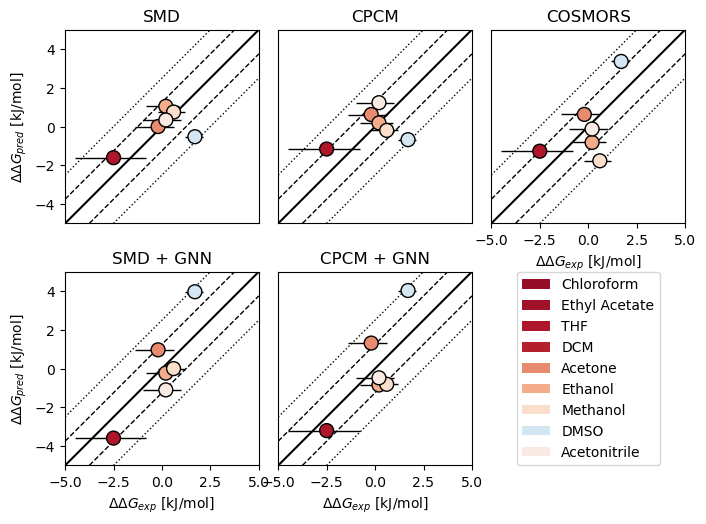

In [929]:
colors = np.array([get_color_from_sd(solvent_dict[solvent]["dielectric"]) for solvent in ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]])

fig, axd = plt.subplot_mosaic([["SMD","CPCM","COSMORS"
                                ],["SMD + GNN","CPCM + GNN",
                                "legend"]],figsize=(8,6),empty_sentinel="X")


ax = axd["legend"]
legend_solvents = solvent_list_rename
ax.legend(handles=[Patch(facecolor=get_color_from_sd(solvent_dict[solvent]['dielectric']),label=solvent_dict[solvent]['nice_name']) for solvent in legend_solvents],loc="center",ncol=1)
ax.axis("off")

# set distance between subplots
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)

adjust = lambda x: x-x.mean()

lim_dict = DefaultDict(lambda :(-5,5))

lim_dict["A1"] = (-5,5)
lim_dict["B1"] = (-5,5)
lim_dict["C1"] = (-10,10)
lim_dict["A3"] = (-10,10)
lims_u, lims_a = lim_dict[molecular_balance_name]

selection = exp_values != -10
marker_dict = {"c":colors[selection],"edgecolors":"k","s":100}

# adjust = lambda x: x
# lims_u = -16
# lims_a = 0
kbt = 2.5/2
for key in axd.keys():
    if key == "legend":
        axd[key].axis("off")
        continue
    ax = axd[key]
    ax.axline([0,0],[1,1],color="k",zorder=0)
    ax.axline([0,0+kbt],[1,1+kbt],color="k",zorder=0,linewidth=1,linestyle="--")
    ax.axline([0,0-kbt],[1,1-kbt],color="k",zorder=0,linewidth=1,linestyle="--")
    ax.axline([0,0+2*kbt],[1,1+2*kbt],color="k",zorder=0,linewidth=1,linestyle="dotted")
    ax.axline([0,0-2*kbt],[1,1-2*kbt],color="k",zorder=0,linewidth=1,linestyle="dotted")
    ax.set_xlim(lims_u,lims_a)
    ax.set_ylim(lims_u,lims_a)
    ax.set_xlabel("$\Delta\Delta G_{exp}$ [kJ/mol]")
    ax.set_ylabel("$\Delta\Delta G_{pred}$ [kJ/mol]")
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

xerr = [np.array(exp_std1)[selection],np.array(exp_std2)[selection]]
axd["SMD"].scatter(adjust(exp_values[selection]),adjust(pre_values[selection]),**marker_dict)
axd["SMD"].errorbar(adjust(exp_values[selection]),adjust(pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["SMD"].set_title("SMD")
axd["SMD + GNN"].scatter(adjust(exp_values[selection]),adjust(gnn_pre_values[selection]),**marker_dict)
axd["SMD + GNN"].errorbar(adjust(exp_values[selection]),adjust(gnn_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["SMD + GNN"].set_title("SMD + GNN")
axd["CPCM"].scatter(adjust(exp_values[selection]),adjust(cpcm_pre_values[selection]),**marker_dict)
axd["CPCM"].errorbar(adjust(exp_values[selection]),adjust(cpcm_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["CPCM"].set_title("CPCM")
axd["CPCM + GNN"].scatter(adjust(exp_values[selection]),adjust(cpcm_gnn_pre_values[selection]),**marker_dict)
axd["CPCM + GNN"].errorbar(adjust(exp_values[selection]),adjust(cpcm_gnn_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["CPCM + GNN"].set_title("CPCM + GNN")
axd["COSMORS"].scatter(adjust(exp_values[selection]),adjust(cosmo_pre_values[selection]),**marker_dict)
axd["COSMORS"].errorbar(adjust(exp_values[selection]),adjust(cosmo_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["COSMORS"].set_title("COSMORS")

for key in axd.keys():
    if key in ["CPCM + GNN","SMD + GNN","COSMORS"]:
        axd[key].get_xaxis().set_visible(True)
    if key in ["SMD","SMD + GNN"]:
        axd[key].get_yaxis().set_visible(True)

fig.savefig("../Analysis/NextGenPlots/SMDvsGNNvsCOSMORSvsCPCM_%s.pdf" % molecular_balance_name,bbox_inches="tight")

In [930]:
from scipy.stats import kendalltau

print(kendalltau(exp_values[selection],pre_values[selection]))
print(kendalltau(exp_values[selection],cosmo_pre_values[selection]))
print(kendalltau(exp_values[selection],cpcm_pre_values[selection]))
print(kendalltau(exp_values[selection],gnn_pre_values[selection]))
print(kendalltau(exp_values[selection],cpcm_gnn_pre_values[selection]))

SignificanceResult(statistic=0.2760262237369417, pvalue=0.44421673013860674)
SignificanceResult(statistic=0.13801311186847084, pvalue=0.7020563949269414)
SignificanceResult(statistic=-0.13801311186847084, pvalue=0.7020563949269414)
SignificanceResult(statistic=0.5520524474738834, pvalue=0.12597116307723114)
SignificanceResult(statistic=0.41403933560541256, pvalue=0.2511180012744736)


#### Plot absolut

/tmp/ipykernel_580347/3731488356.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5)
/tmp/ipykernel_580347/3731488356.py:9: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.5)


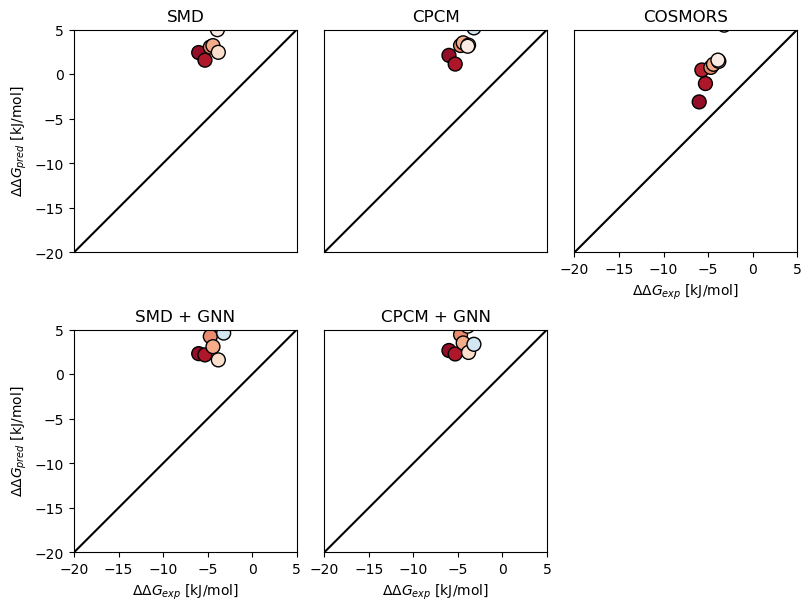

In [891]:
colors = np.array([get_color_from_sd(solvent_dict[solvent]["dielectric"]) for solvent in ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]])

fig, axd = plt.subplot_mosaic([["SMD","CPCM","COSMORS"
                                ],["SMD + GNN","CPCM + GNN",
                                "X"]],figsize=(8,6),empty_sentinel="X",constrained_layout=True)

# set distance between subplots
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

adjust = lambda x: x
lims_u = -20
lims_a = 5

selection = exp_values != -10
marker_dict = {"c":colors[selection],"edgecolors":"k","s":100}

# adjust = lambda x: x
# lims_u = -16
# lims_a = 0

for key in axd.keys():
    if key == "EMPTY":
        axd[key].axis("off")
        continue
    ax = axd[key]
    ax.axline([0,0],[1,1],color="k",zorder=0)
    ax.set_xlim(lims_u,lims_a)
    ax.set_ylim(lims_u,lims_a)
    ax.set_xlabel("$\Delta\Delta G_{exp}$ [kJ/mol]")
    ax.set_ylabel("$\Delta\Delta G_{pred}$ [kJ/mol]")
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

xerr = [np.array(exp_std1)[selection],np.array(exp_std2)[selection]]
axd["SMD"].scatter(adjust(exp_values[selection]),adjust(pre_values[selection]),**marker_dict)
axd["SMD"].errorbar(adjust(exp_values[selection]),adjust(pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["SMD"].set_title("SMD")
axd["SMD + GNN"].scatter(adjust(exp_values[selection]),adjust(gnn_pre_values[selection]),**marker_dict)
axd["SMD + GNN"].errorbar(adjust(exp_values[selection]),adjust(gnn_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["SMD + GNN"].set_title("SMD + GNN")
axd["CPCM"].scatter(adjust(exp_values[selection]),adjust(cpcm_pre_values[selection]),**marker_dict)
axd["CPCM"].errorbar(adjust(exp_values[selection]),adjust(cpcm_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["CPCM"].set_title("CPCM")
axd["CPCM + GNN"].scatter(adjust(exp_values[selection]),adjust(cpcm_gnn_pre_values[selection]),**marker_dict)
axd["CPCM + GNN"].errorbar(adjust(exp_values[selection]),adjust(cpcm_gnn_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["CPCM + GNN"].set_title("CPCM + GNN")
axd["COSMORS"].scatter(adjust(exp_values[selection]),adjust(cosmo_pre_values[selection]),**marker_dict)
axd["COSMORS"].errorbar(adjust(exp_values[selection]),adjust(cosmo_pre_values[selection]),xerr=xerr,fmt="none",ecolor="k",elinewidth=1,zorder=0)
axd["COSMORS"].set_title("COSMORS")

for key in axd.keys():
    if key in ["CPCM + GNN","SMD + GNN","COSMORS"]:
        axd[key].get_xaxis().set_visible(True)
    if key in ["SMD","SMD + GNN"]:
        axd[key].get_yaxis().set_visible(True)

fig.savefig("../Analysis/NextGenPlots/SMDvsGNNvsCOSMORSvsCPCM_abs_%s.pdf" % molecular_balance_name,bbox_inches="tight")

In [949]:
6/10*100000*17000000 / 60 / 8000 / 24 / 365

242.5799086757991

In [936]:
calc_mb_names = ["A1","A2","A3","A4","B1","C1","D1"]

In [937]:
# Read in COSOMO-RS results
cosmo_trajs, cosmo_energies, cosmo_ds, cosmo_deltas, cosmo_populations = {}, {}, {}, {}, {}
cpcm_trajs, cpcm_energies, cpcm_ds, cpcm_deltas, cpcm_populations = {}, {}, {}, {}, {}
smd_gnn_trajs, smd_gnn_energies, smd_gnn_ds, smd_gnn_deltas, smd_gnn_populations = {}, {}, {}, {}, {}
cpcm_gnn_trajs, cpcm_gnn_energies, cpcm_gnn_ds, cpcm_gnn_deltas, cpcm_gnn_populations = {}, {}, {}, {}, {}

submission_string = ""

kendalltaus = {}

for molecular_balance_name in calc_mb_names:

    solvent_list_rename = ["Chloroform","Ethylacetate","THF","DCM","acetone","Ethanol","Methanol","DMSO","acetonitrile"]
    df = pd.read_csv("../Analysis/MB_experimental_references.csv",index_col=0)[molecular_balance_name]
    # df["Ethylacetate"] = '(-10,2,0)'
    exp_values = np.array([eval(df[solvent].replace("nan","-10"))[0] for solvent in solvent_list_rename])
    exp_std1 = np.array([eval(df[solvent].replace("nan","-10"))[1] for solvent in solvent_list_rename])
    exp_std2 = np.array([eval(df[solvent].replace("nan","-10"))[2] for solvent in solvent_list_rename])

    for solvent,so_rename in zip(solvent_list,solvent_list_rename):
        traj = mdtraj.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{so_rename}_cluster_center.h5")
        ene = np.load(f"../Analysis/MB_results/{molecular_balance_name}/{molecular_balance_name}_{so_rename}_cluster_center_free_energy.npy")
        ref_traj = select_frames_based_on_dihedral(traj,ene,thresh=10)
        orca_trajs[solvent], orca_energies[solvent], orca_ds[solvent], orca_deltas[solvent], orca_populations[solvent] = \
        collect_results(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
        cosmo_trajs[solvent], cosmo_energies[solvent], cosmo_populations[solvent] = \
        collect_results_COSMORS(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
        cpcm_trajs[solvent], cpcm_energies[solvent], cpcm_populations[solvent] = \
        collect_results_CPCM(f"/localhome/kpaul/small_molecule_multisolvent/Simulation/QM_reference_calculations_Molecular_Balances/{molecular_balance_name}/",so_rename,ref_traj)
        all_gnn_energies[molecular_balance_name][solvent] = calculate_GNN_delta(ref_traj,all_gnn_energies,solvent,so_rename)
        smd_gnn_trajs[solvent], smd_gnn_energies[solvent], smd_gnn_populations[solvent] = \
        adjust_energies(orca_energies[solvent],all_gnn_energies[molecular_balance_name][solvent],orca_trajs[solvent])
        cpcm_gnn_trajs[solvent], cpcm_gnn_energies[solvent], cpcm_gnn_populations[solvent] = \
        adjust_energies(cpcm_energies[solvent],all_gnn_energies[molecular_balance_name][solvent],cpcm_trajs[solvent])
    
    pre_values = np.array([in_kjmol(np.array([orca_populations[solvent],1-orca_populations[solvent]]))[1]*-1 for solvent in solvent_list])
    gnn_pre_values = np.array([in_kjmol(np.array([smd_gnn_populations[solvent],1-smd_gnn_populations[solvent]]))[1]*-1 for solvent in solvent_list])
    cosmo_pre_values = np.array([in_kjmol(np.array([cosmo_populations[solvent],1-cosmo_populations[solvent]]))[1]*-1 for solvent in solvent_list])
    cpcm_pre_values = np.array([in_kjmol(np.array([cpcm_populations[solvent],1-cpcm_populations[solvent]]))[1]*-1 for solvent in solvent_list])
    cpcm_gnn_pre_values = np.array([in_kjmol(np.array([cpcm_gnn_populations[solvent],1-cpcm_gnn_populations[solvent]]))[1]*-1 for solvent in solvent_list])
    
    kendalltaus[molecular_balance_name] = {}
    kendalltaus[molecular_balance_name]["SMD"] = kendalltau(exp_values[selection],pre_values[selection])
    kendalltaus[molecular_balance_name]["COSMORS"] = kendalltau(exp_values[selection],cosmo_pre_values[selection])
    kendalltaus[molecular_balance_name]["CPCM"] = kendalltau(exp_values[selection],cpcm_pre_values[selection])
    kendalltaus[molecular_balance_name]["SMD + GNN"] = kendalltau(exp_values[selection],gnn_pre_values[selection])
    kendalltaus[molecular_balance_name]["CPCM + GNN"] = kendalltau(exp_values[selection],cpcm_gnn_pre_values[selection])


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

Energy is 0
Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0
Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs i

Energy is 0


/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [938]:
SMD_kendalltaus = np.array([kendalltaus[molecular_balance_name]["SMD"][0] for molecular_balance_name in calc_mb_names])
COSMORS_kendalltaus = np.array([kendalltaus[molecular_balance_name]["COSMORS"][0] for molecular_balance_name in calc_mb_names])
CPCM_kendalltaus = np.array([kendalltaus[molecular_balance_name]["CPCM"][0] for molecular_balance_name in calc_mb_names])
SMD_GNN_kendalltaus = np.array([kendalltaus[molecular_balance_name]["SMD + GNN"][0] for molecular_balance_name in calc_mb_names])
CPCM_GNN_kendalltaus = np.array([kendalltaus[molecular_balance_name]["CPCM + GNN"][0] for molecular_balance_name in calc_mb_names])

In [939]:
kendalltaus

{'A1': {'SMD': SignificanceResult(statistic=0.2760262237369417, pvalue=0.44421673013860674),
  'COSMORS': SignificanceResult(statistic=0.13801311186847084, pvalue=0.7020563949269414),
  'CPCM': SignificanceResult(statistic=-0.13801311186847084, pvalue=0.7020563949269414),
  'SMD + GNN': SignificanceResult(statistic=0.5520524474738834, pvalue=0.12597116307723114),
  'CPCM + GNN': SignificanceResult(statistic=0.41403933560541256, pvalue=0.2511180012744736)},
 'A2': {'SMD': SignificanceResult(statistic=0.2, pvalue=0.7194444444444444),
  'COSMORS': SignificanceResult(statistic=-0.06666666666666665, pvalue=1.0),
  'CPCM': SignificanceResult(statistic=0.3333333333333333, pvalue=0.46944444444444444),
  'SMD + GNN': SignificanceResult(statistic=0.7333333333333333, pvalue=0.05555555555555555),
  'CPCM + GNN': SignificanceResult(statistic=0.6, pvalue=0.1361111111111111)},
 'A3': {'SMD': SignificanceResult(statistic=-0.13801311186847084, pvalue=0.7020563949269414),
  'COSMORS': SignificanceResult

(-1.0, 1.0)

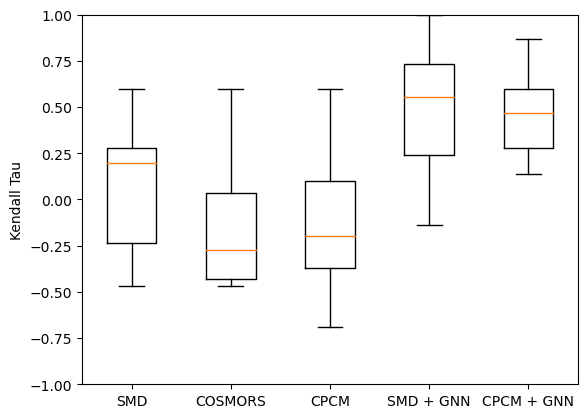

In [940]:
plt.boxplot([SMD_kendalltaus,COSMORS_kendalltaus,CPCM_kendalltaus,SMD_GNN_kendalltaus,CPCM_GNN_kendalltaus])
plt.xticks([1,2,3,4,5],["SMD","COSMORS","CPCM","SMD + GNN","CPCM + GNN"])
plt.ylabel("Kendall Tau")
plt.ylim(-1,1)
